# Split 7:3

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [2]:
df = pd.read_csv('../../Data/fpt_data_sheet.csv')
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1248,2024-02-26,103900,108000,103500,108000,4466700,FPT
1249,2024-02-27,108500,109500,107400,107900,2800800,FPT
1250,2024-02-28,108000,108500,106300,108500,3461700,FPT
1251,2024-02-29,108200,109400,107700,109000,2824800,FPT


In [3]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume', 'ticker'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [4]:
df['time'] = pd.to_datetime(df['time'])

In [5]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1253 non-null   datetime64[ns]
 1   close   1253 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [6]:
df = df.set_index('time')

In [7]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

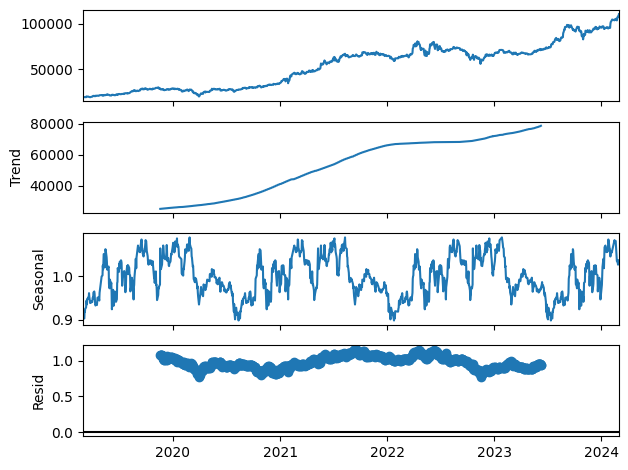

In [8]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [9]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [10]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [11]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=249, damped_trend=True)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

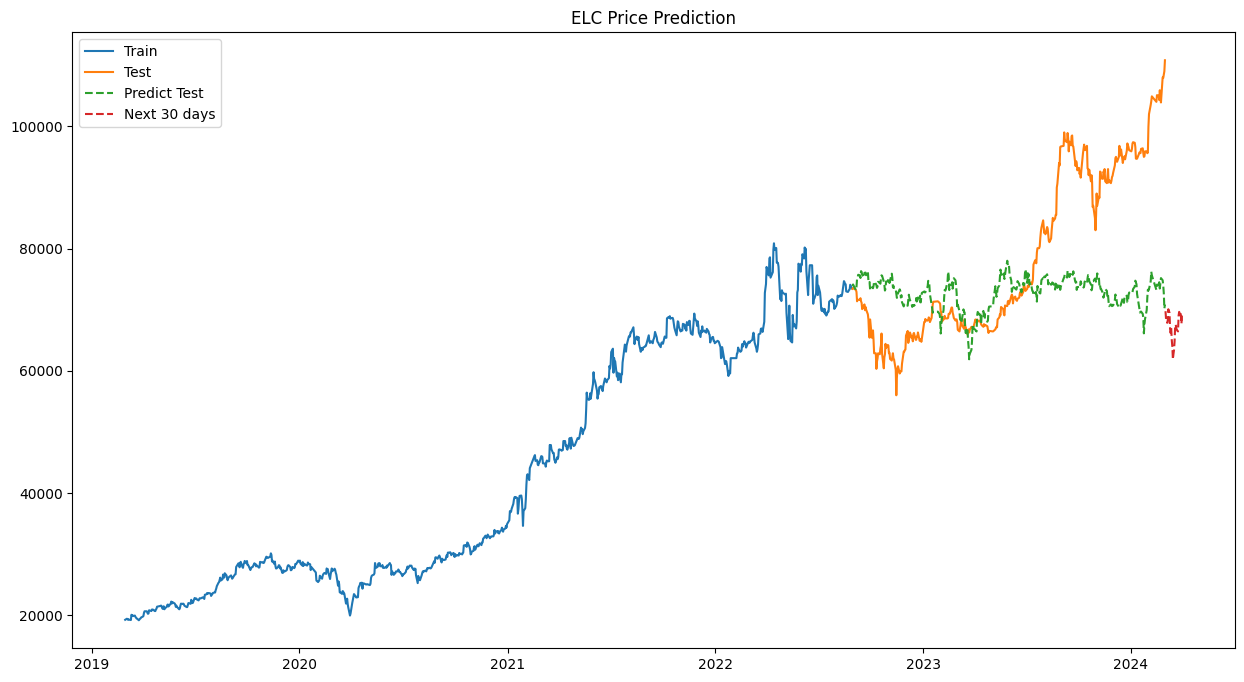

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index, train['close'], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [14]:
evaluateModel(test, pred)

** Testing **
MAE:  11277.875513587414
MAPE:  13.280275131296099
RMSE:  14500.105187614223
MSLE: 0.031302867998573576


In [15]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                  877
Model:             ExponentialSmoothing   SSE                      837999112.283
Optimized:                         True   AIC                          12584.308
Trend:                   Multiplicative   BIC                          13797.541
Seasonal:                Multiplicative   AICC                         12796.540
Seasonal Periods:                   249   Date:                 Wed, 15 May 2024
Box-Cox:                          False   Time:                         20:15:06
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9596429                alpha                 True
smoothing_trend       

# Split 8:2

In [16]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [17]:
df = pd.read_csv('../../Data/fpt_data_sheet.csv')
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1248,2024-02-26,103900,108000,103500,108000,4466700,FPT
1249,2024-02-27,108500,109500,107400,107900,2800800,FPT
1250,2024-02-28,108000,108500,106300,108500,3461700,FPT
1251,2024-02-29,108200,109400,107700,109000,2824800,FPT


In [18]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume', 'ticker'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [19]:
df['time'] = pd.to_datetime(df['time'])

In [20]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1253 non-null   datetime64[ns]
 1   close   1253 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [21]:
df = df.set_index('time')

In [22]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

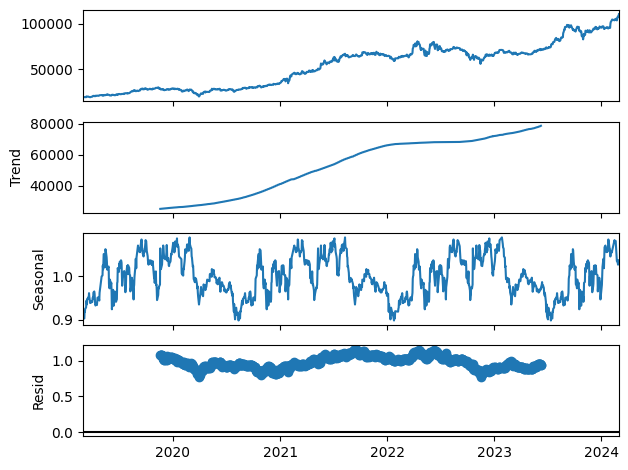

In [23]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [24]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [25]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [26]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=298, damped_trend=True)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

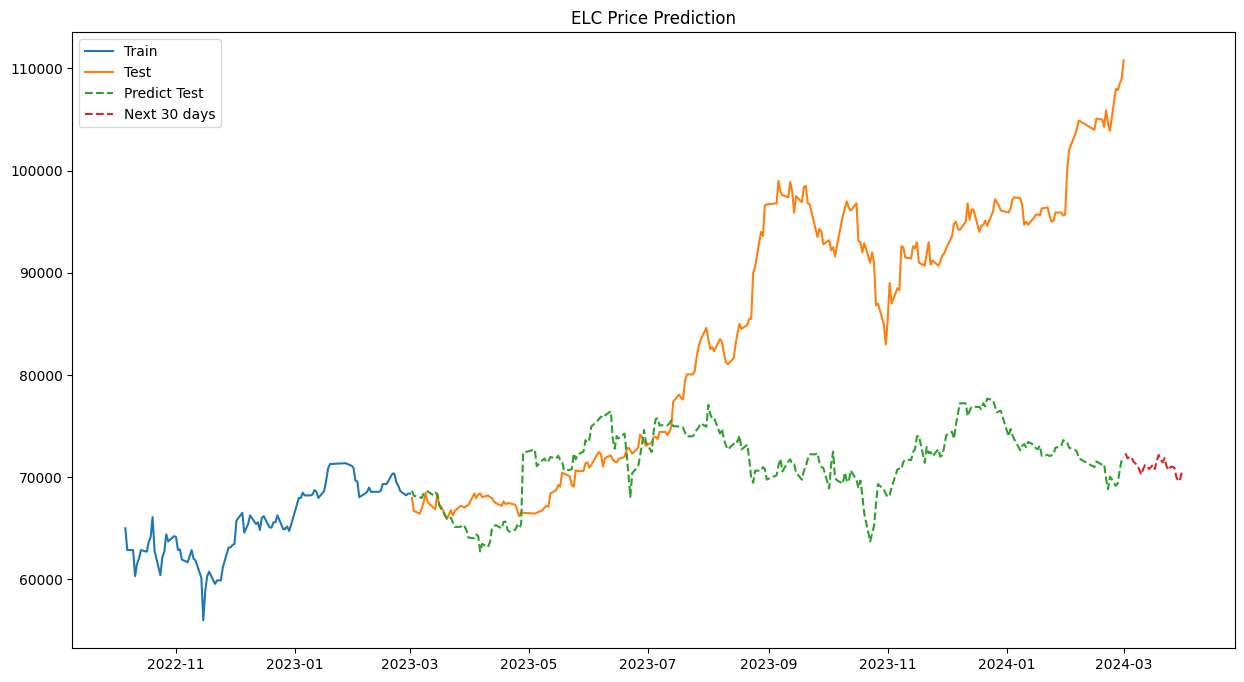

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [29]:
evaluateModel(test, pred)

** Testing **
MAE:  13838.507023183804
MAPE:  14.878486241054398
RMSE:  17608.12138584406
MSLE: 0.04461964303742379


In [30]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1002
Model:             ExponentialSmoothing   SSE                     1110470412.033
Optimized:                         True   AIC                          14552.133
Trend:                   Multiplicative   BIC                          16039.788
Seasonal:                Multiplicative   AICC                         14820.323
Seasonal Periods:                   298   Date:                 Wed, 15 May 2024
Box-Cox:                          False   Time:                         20:15:10
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Split 9:1

In [31]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [32]:
df = pd.read_csv('../../Data/fpt_data_sheet.csv')
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1248,2024-02-26,103900,108000,103500,108000,4466700,FPT
1249,2024-02-27,108500,109500,107400,107900,2800800,FPT
1250,2024-02-28,108000,108500,106300,108500,3461700,FPT
1251,2024-02-29,108200,109400,107700,109000,2824800,FPT


In [33]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume', 'ticker'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [34]:
df['time'] = pd.to_datetime(df['time'])

In [35]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1253 non-null   datetime64[ns]
 1   close   1253 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [36]:
df = df.set_index('time')

In [37]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

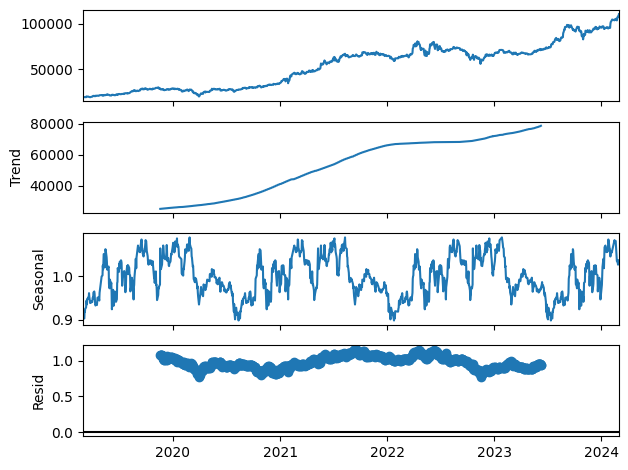

In [38]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [39]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [40]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

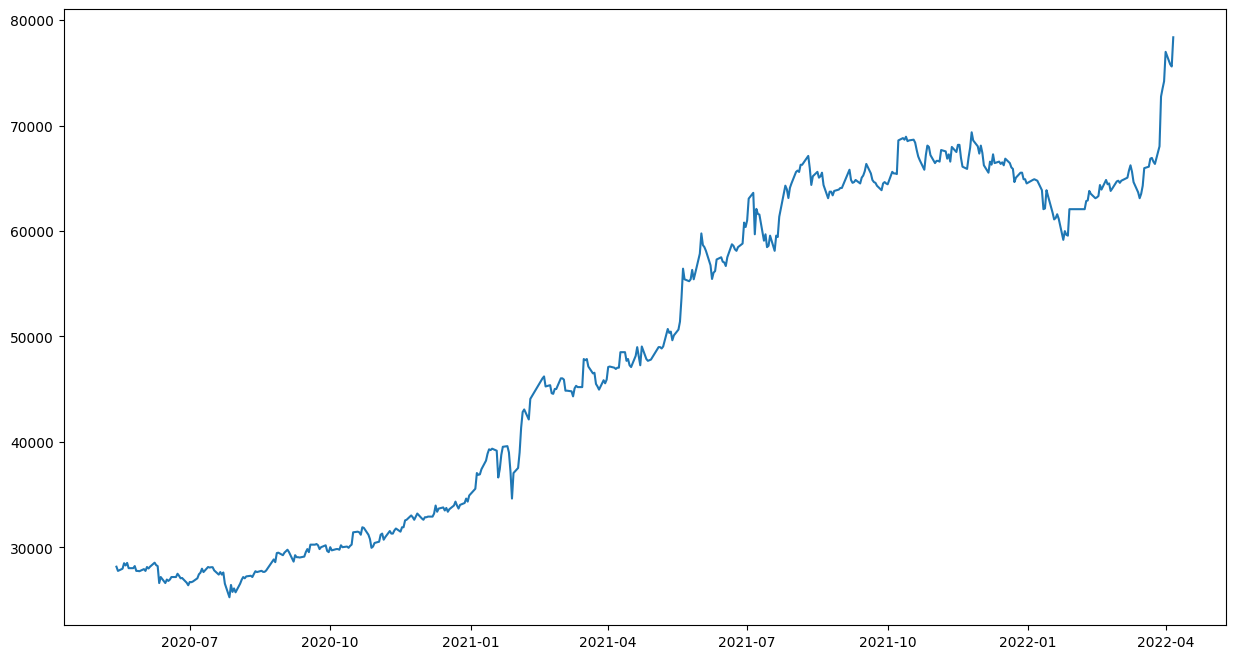

In [41]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['close'][300:777]);

In [42]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=348, damped_trend=True)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [43]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

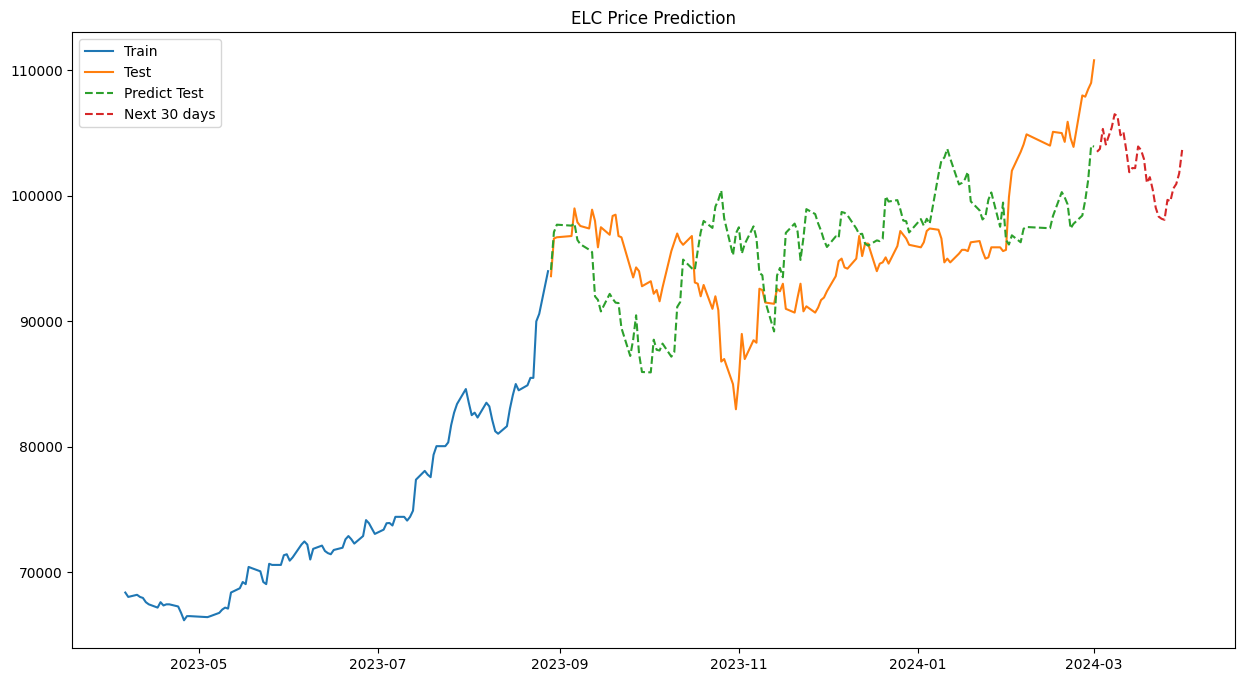

In [44]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [45]:
evaluateModel(test, pred)

** Testing **
MAE:  4697.367554702268
MAPE:  4.953673469937163
RMSE:  5556.236577251657
MSLE: 0.0034103643267599723


In [46]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1127
Model:             ExponentialSmoothing   SSE                      808382377.026
Optimized:                         True   AIC                          15901.602
Trend:                   Multiplicative   BIC                          17676.244
Seasonal:                Multiplicative   AICC                         16229.436
Seasonal Periods:                   348   Date:                 Wed, 15 May 2024
Box-Cox:                          False   Time:                         20:15:13
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       